# Conducting Scaling Experiments with Modalities

In this tutorial, we showcase how the profiling and benchmark tooling within Modalities can be used to determine the training configurations that maximize throughput for a varying number of ranks (i.e., scaling benchmarks).

Generally, there are two types of scaling benchmarkings. In the first case, one wants demonstrate linear scalability of the framework on a given HPC cluster. By varying the configuration parameters most relevant for efficiency (e.g., batch size and activation checkpointing variant), we determine the maximum throughput across different number of ranks. Plotting the maximum throughput against the number of ranks should yield a linear relationship.

In the second case, we only want to determine the optimal settings for a fixed number of ranks and perform a higher dimensional and more granular grid search. This is typically the case, when you received a GPU allocation on an HPC cluster and want to maximize the efficiency of your specific training run. 

In this tutorial, we will cover both cases in the following sections.

The file tree provides an overview on the overall setup:

```txt
.
├── scaling_tutorial.ipynb      # The actual tutorial with code and explantations
├── config_8B_scaling.yaml      # The 8B model benchmarking config including grid search definition
├── experiments                 # Here, the results will be stored
├── logs                        # Here, the logs will be stored (error and stdout)
├── README.md                   # Overview on the tutorial
├── run_array_jobs.sh           # Submits the scaling experiments by calling the sbatch script`submit_job.sbatch` (once per node configuration)
├── scaling_grid_search.py      # CMD entrypoint that runs the grid search on a fixed number of ranks
└── submit_job.sbatch           # Submits the grid search for a fixed number of ranks to slurm and internally calls `scaling_grid_search.py`.
```

Note, that this tutorial is partially specific to the Leonardo supercomputer (e.g., parts of `submit_job.sbatch`) and while we tried to minimize this dependency some settings nevertheless have to be adapted for other HPC clusters. We mention these cases throughout the tutorial.  

## Scaling benchmarks across varying number of ranks


In this section, we want to verify the linear scalability of Modalities. 

## Running the scaling experiments
To do so, we will run a grid search over the batch size and sequence length for a varying number of ranks, as defined in `config_8B_scaling.yaml`. 


```yaml
  grid_search:
    sequence_length: [8192]     # Fixed
    vocab_size: [50304]         # Fixed
    batch_size: [1, 2, 3, 4]    # Varied 
```


When generating the concrete configurations for the grid search, the batch size array will be replaced with the concrete scalar value. Throughout the config the values are referenced, as shown below for the `dataset_batch_generator` component:

```yaml
dataset_batch_generator:
  component_key: dataset_batch_generator
  variant_key: random
  config:
    vocab_size: ${settings.grid_search.vocab_size}
    sequence_length: ${settings.grid_search.sequence_length}
    batch_size: ${settings.grid_search.batch_size}
```


The model itself is a standard LLama-like 8B model, fully sharded with FSDP2 and optimized with AdamW.
In contrast to the normal training runs, we don't specify an actual dataset. Instead we generate random batches with random tokens. 

The results and logs will be stored in the `experiments` and `logs` folder, respectively.


We submit the job array for different number of ranks via `sh run_array_jobs.sh <list of number of ranks>`. Each job will then run the grid search for the respective number of ranks by calling the sbatch script `submit_job.sbatch`. The sbatch script is responsible for setting up the environment and calling the actual grid search script `scaling_grid_search.py`.

**Note that, the specified** `partition`, `account`, `qos`, `gres` **(number of GPUs per node),** `cpus-per-task` **and loaded python environment and modules are specific to the Leonardo supercomputer and would have to be adapted for other HPC clusters.**

In [26]:
! sh run_array_jobs.sh 1 2 4 8 16 32 

Submitting job with 1 node(s)...
Submitted batch job 16360417
Submitting job with 2 node(s)...
Submitted batch job 16360418
Submitting job with 4 node(s)...
Submitted batch job 16360419
Submitting job with 8 node(s)...
Submitted batch job 16360420
Submitting job with 16 node(s)...
Submitted batch job 16360421
Submitting job with 32 node(s)...
Submitted batch job 16360422


After all jobs have finished, the results can be found in the `experiments` folder, following the structure `num_ranks_<number of ranks>/<config hash value>_<rank_id>.json`.

```txt
experiments/2025-06-03__18-03-46/
├── num_ranks_4
│   ├── 20269a77_0.json
│   ├── 20269a77_1.json
│   ├── 20269a77_2.json
│   ...
│   ├── e9ab8d32_1.json
│   ├── e9ab8d32_2.json
│   └── e9ab8d32_3.json
└── num_ranks_8
    ├── 20269a77_0.json
    ├── 20269a77_1.json
    ├── 20269a77_2.json
    ...
    ├── e9ab8d32_5.json
    ├── e9ab8d32_6.json
    └── e9ab8d32_7.json
```


We perform rank-wise measurements, tracking the grid search config, environment information and the actual measurement results (peak memory, forward time, backward time and step time). If the job failed, e.g., due to an OOM due to batch size being too large, the error message is also stored in the result file.

```json
{
    "grid_search_config": {
        "batch_size": 1,
        "sequence_length": 4096,
        "vocab_size": 50304
    },
    "env_info": {
        "local_rank": 0,
        "global_rank": 0,
        "num_ranks": 8,
        "hostname": "lrdn1323.leonardo.local"
    },
    "measurement": {
        "peak_memory": 34438.70068359375,
        "forward_time": 0.057291507720947266,
        "backward_time": 0.5151477009057999,
        "step_time": 0.17779622972011566
    },
    "error": ""
}
```

## Analyzing the results

To determine the scalability of Modalities, we load the all the results from the experiments folder (i.e., `experiments/2025-06-03__18-03-46/`) into memory. 

In [62]:
import pandas as pd
from modalities.utils.profilers.profile_logs_analyzers import ProfileLogsAnalyzer
from modalities.utils.profilers.modalities_profiler import ProfilingResult
from pathlib import Path
import matplotlib.pyplot as plt

In [63]:
experiment_folder_path = Path("experiments/2025-06-03__19-12-57")
experiment_dirs = list(experiment_folder_path.glob("*"))
experiment_dirs

[PosixPath('experiments/2025-06-03__19-12-57/num_ranks_128')]

In [64]:
grid_search_dims = ["batch_size", "sequence_length", "num_ranks"]

In [65]:
results_list: list[pd.DataFrame] = []
for experiment_dir in experiment_dirs:
    results: list[ProfilingResult] = ProfileLogsAnalyzer.load_profiling_logs(experiment_dir)
    df: pd.DataFrame = ProfileLogsAnalyzer.to_pandas_df(results)
    results_list.append(df)

df_results = pd.concat(results_list, ignore_index=True)
df_results.head()

,batch_size,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error
0,3,4096,50304,3,35,128,lrdn1313.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory. Tried to allocate 336.00 M...
1,2,8192,50304,3,51,128,lrdn1399.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory. Tried to allocate 112.00 M...
2,1,8192,50304,1,85,128,lrdn1495.leonardo.local,46901.129395,0.057825,1.768893,0.116611,
3,3,4096,50304,2,114,128,lrdn1575.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory. Tried to allocate 336.00 M...
4,2,8192,50304,2,42,128,lrdn1329.leonardo.local,-1.000000,-1.000000,-1.000000,-1.000000,CUDA out of memory. Tried to allocate 112.00 M...


In [66]:
df_results["total_step_time"] = df_results["forward_time"] + df_results["backward_time"] + df_results["step_time"]
df_results["token_throughput"] = df_results["sequence_length"] * df_results["batch_size"] / df_results["total_step_time"]
df_results["sample_throughput"] = df_results["token_throughput"] / df_results["sequence_length"]
df_results["error"] = df_results["error"].apply(lambda x: x[:20])

df_results.sort_values(by=["total_step_time"], inplace=True, ascending=True)
df_results.head()


,batch_size,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error,total_step_time,token_throughput,sample_throughput
613,4,4096,50304,3,11,128,lrdn0967.leonardo.local,-1.0,-1.0,-1.0,-1.0,CUDA out of memory.,-3.0,-5461.333333,-1.333333
599,2,8192,50304,0,4,128,lrdn0900.leonardo.local,-1.0,-1.0,-1.0,-1.0,CUDA out of memory.,-3.0,-5461.333333,-0.666667
601,4,8192,50304,2,22,128,lrdn1086.leonardo.local,-1.0,-1.0,-1.0,-1.0,CUDA out of memory.,-3.0,-10922.666667,-1.333333
602,3,8192,50304,0,28,128,lrdn1291.leonardo.local,-1.0,-1.0,-1.0,-1.0,CUDA out of memory.,-3.0,-8192.000000,-1.000000
603,2,8192,50304,3,123,128,lrdn1602.leonardo.local,-1.0,-1.0,-1.0,-1.0,CUDA out of memory.,-3.0,-5461.333333,-0.666667


In [67]:
df_results = df_results[df_results["error"] == ""]
df_results.head()

,batch_size,sequence_length,vocab_size,local_rank,global_rank,num_ranks,hostname,peak_memory,forward_time,backward_time,step_time,error,total_step_time,token_throughput,sample_throughput
872,1,4096,50304,2,10,128,lrdn0967.leonardo.local,24540.973145,0.056713,1.357325,0.058721,,1.472760,2781.172442,0.678997
921,1,4096,50304,0,8,128,lrdn0967.leonardo.local,24540.973145,0.056930,1.357248,0.058586,,1.472764,2781.164957,0.678995
895,1,4096,50304,3,11,128,lrdn0967.leonardo.local,24540.973145,0.058338,1.355948,0.058497,,1.472783,2781.129023,0.678987
327,1,4096,50304,1,9,128,lrdn0967.leonardo.local,24540.973145,0.058831,1.355251,0.058702,,1.472785,2781.126040,0.678986
703,1,4096,50304,3,7,128,lrdn0900.leonardo.local,24540.973145,0.056520,1.357765,0.058668,,1.472952,2780.810052,0.678909


In [68]:
# aggregate over the ranks of each experiment
agg_df = df_results.groupby(grid_search_dims).agg({
        "token_throughput": "sum",
        "sample_throughput": "sum",
        "peak_memory": "max"
    }).reset_index()

agg_df.head()

,batch_size,sequence_length,num_ranks,token_throughput,sample_throughput,peak_memory
0,1,4096,128,355010.139209,86.672397,24540.973145
1,1,8192,128,538741.932482,65.764396,46901.129395
2,2,4096,128,507098.332855,123.803304,46834.816895


# Scaling number of ranks

In [69]:
# Group by 'num_ranks' and 'sequence_length' and keep row with max 'token_throughput'
filtered_df = agg_df.loc[agg_df.groupby(['num_ranks', 'sequence_length'])['token_throughput'].idxmax()]

# Optional: reset the index if you want a clean DataFrame
filtered_df = filtered_df.reset_index(drop=True)
filtered_df

,batch_size,sequence_length,num_ranks,token_throughput,sample_throughput,peak_memory
0,2,4096,128,507098.332855,123.803304,46834.816895
1,1,8192,128,538741.932482,65.764396,46901.129395


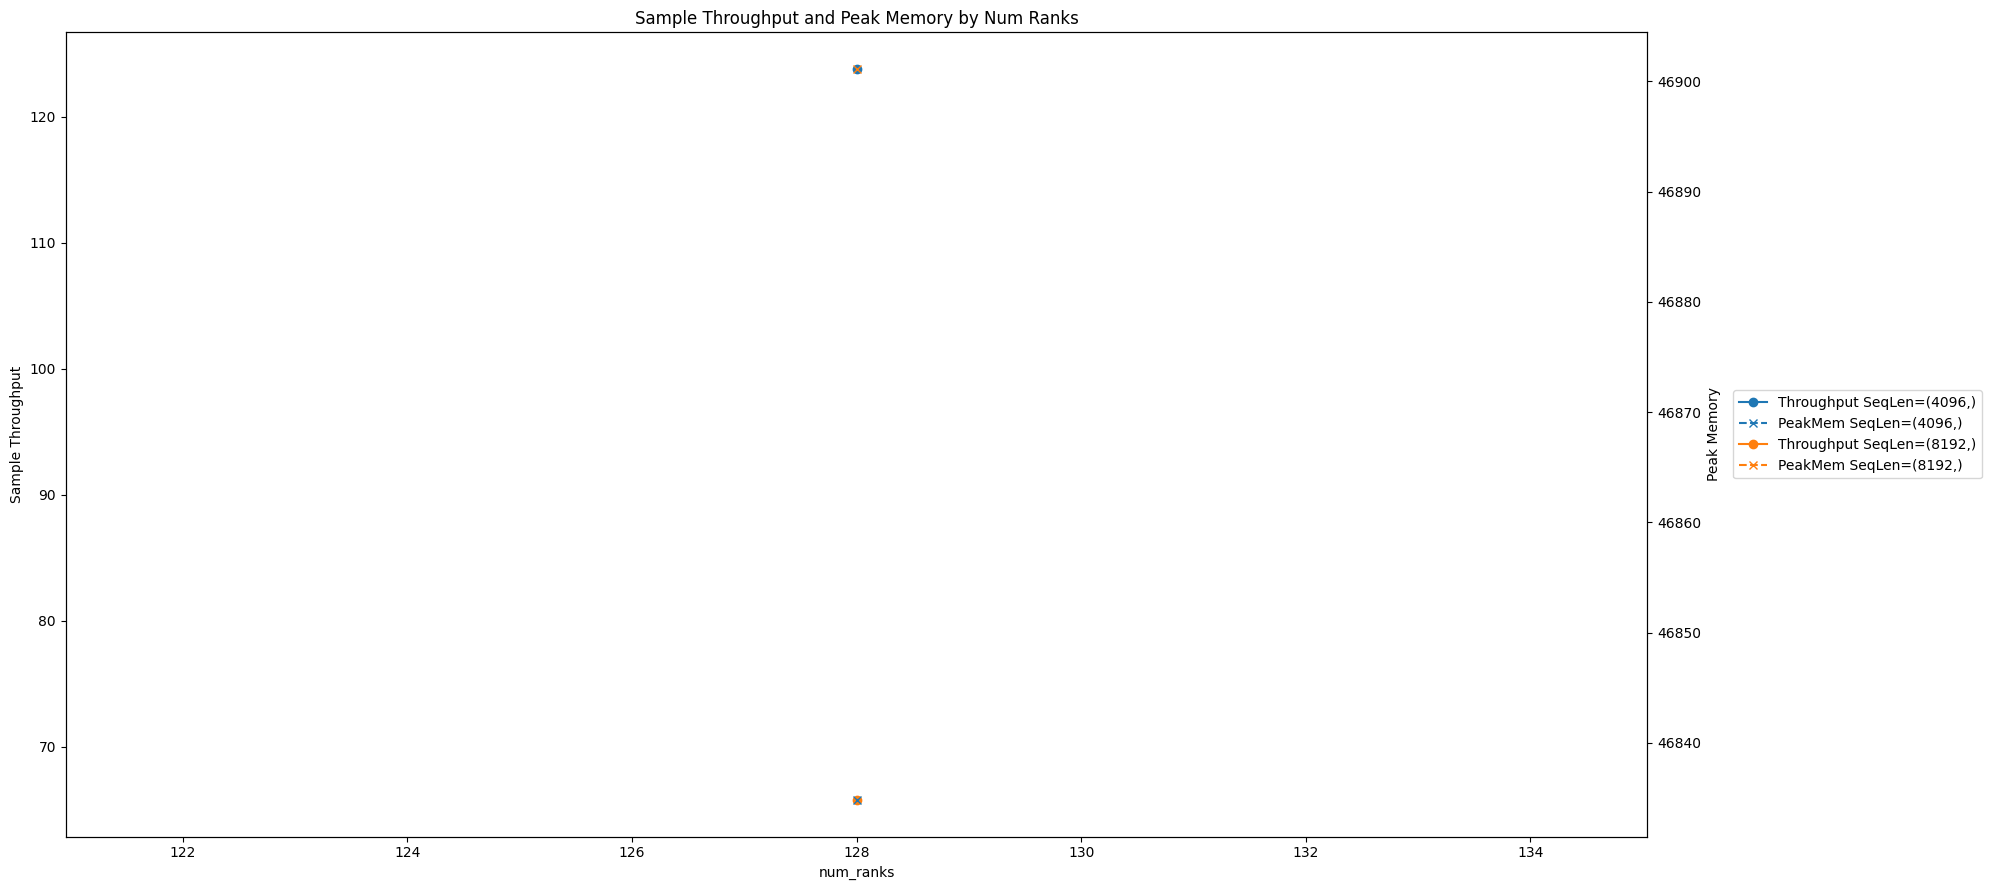

In [61]:

# Plot token throughput
fig, ax1 = plt.subplots(figsize=(20, 9))
ax2 = ax1.twinx()

# Store all line handles and labels for a single legend later
lines = []
labels = []

# Group by sequence_length and batch_size
for (seq_len), group in filtered_df.groupby(['sequence_length']):
    label = f'SeqLen={seq_len}'
    
    group_sorted = group.sort_values('num_ranks')
    
    # Plot sample_throughput
    l1, = ax1.plot(group_sorted['num_ranks'], group_sorted['sample_throughput'],
                   marker='o', label=f'Sample Throughput {label}')
    lines.append(l1)
    labels.append(f'Throughput {label}')
    
    # Plot peak_memory
    l2, = ax2.plot(group_sorted['num_ranks'], group_sorted['peak_memory'],
                   marker='x', linestyle='--', label=f'PeakMem {label}')
    lines.append(l2)
    labels.append(f'PeakMem {label}')

# Labels and titles
ax1.set_xlabel('num_ranks')
ax1.set_ylabel('Sample Throughput')
ax2.set_ylabel('Peak Memory')
ax1.set_title('Sample Throughput and Peak Memory by Num Ranks')

# Single combined legend
ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.05, 0.5))

plt.tight_layout()
plt.show()



# Throughput degradation when hitting the memory limits

In [128]:
agg_df.head()

,batch_size,sequence_length,num_ranks,token_throughput,sample_throughput,peak_memory
0,1,2048,4,15450.465429,7.544173,35296.321289
1,1,2048,8,26673.647026,13.024242,23768.926758
2,1,2048,16,38688.335005,18.890789,18431.541992
3,1,2048,32,92871.497194,45.347411,15761.099609
4,1,2048,64,149792.799173,73.141015,14428.253906


In [131]:
# Assuming your DataFrame is named 'agg_df'

# Step 1: Find the maximum peak_memory per group
max_peak_per_group = (
    agg_df.groupby(['sequence_length', 'num_ranks'])['peak_memory']
    .max()
    .reset_index()
)

# Step 2: Sort groups by peak_memory descending and pick the top 5 groups
top_5_groups = (
    max_peak_per_group
    .sort_values(by='peak_memory', ascending=False)
    .head(10)
)

# Step 3: Filter the original DataFrame to include only rows from the top 5 groups
df_filtered = agg_df.merge(
    top_5_groups[['sequence_length', 'num_ranks']],
    on=['sequence_length', 'num_ranks'],
    how='inner'
)
df_filtered

,batch_size,sequence_length,num_ranks,token_throughput,sample_throughput,peak_memory
0,1,2048,4,15450.465429,7.544173,35296.321289
1,1,4096,8,43888.987497,10.715085,34438.700684
2,1,4096,16,73418.926608,17.924543,29153.319824
3,1,4096,32,177042.814595,43.223343,26510.754395
4,1,4096,64,280870.073765,68.571795,25190.973145
5,1,8192,8,25915.286031,3.163487,56797.747559
6,1,8192,16,98019.025533,11.965213,51513.366699
7,1,8192,32,212074.960940,25.888057,48874.926270
8,1,8192,64,402426.102732,49.124280,47567.082520
9,1,8192,128,802580.415539,97.971242,46901.129395


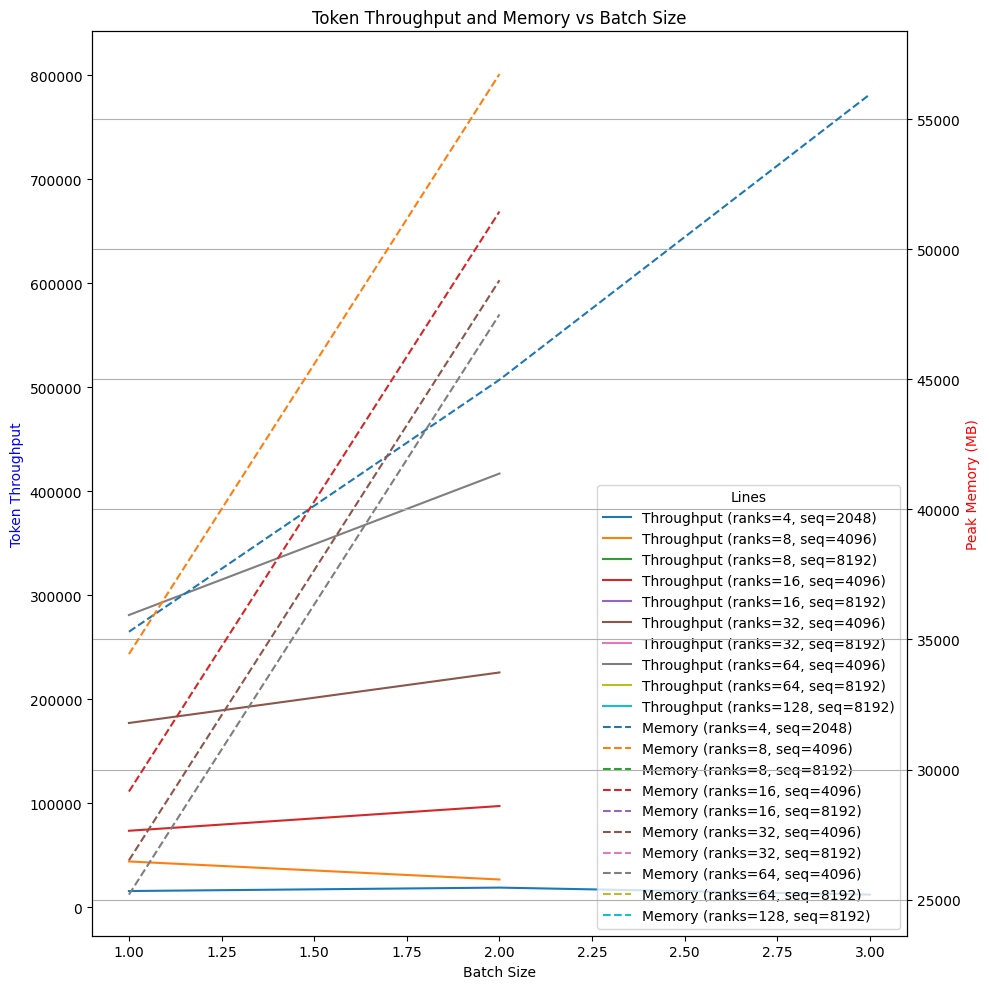

In [132]:
# Clean data
df = df_filtered[(df_filtered["token_throughput"] > 0) & (df_filtered["peak_memory"] > 0)]

# Start figure
fig, ax1 = plt.subplots(figsize=(10, 10))
ax2 = ax1.twinx()

# Color cycle for consistency across axes
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, ((num_ranks, seq_len), group) in enumerate(df.groupby(["num_ranks", "sequence_length"])):
    color = colors[i % len(colors)]
    
    # Aggregate by batch_size
    grouped = group.groupby("batch_size").agg({
        "token_throughput": "sum",
        "peak_memory": "max"
    })

    ax1.plot(grouped.index, grouped["token_throughput"], label=f"Throughput (ranks={num_ranks}, seq={seq_len})", color=color, linestyle='-')
    ax2.plot(grouped.index, grouped["peak_memory"], label=f"Memory (ranks={num_ranks}, seq={seq_len})", color=color, linestyle='--')

# Labels and legends
ax1.set_xlabel("Batch Size")
ax1.set_ylabel("Token Throughput", color='blue')
ax2.set_ylabel("Peak Memory (MB)", color='red')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="lower right", title="Lines")

plt.title("Token Throughput and Memory vs Batch Size")
plt.grid(True)
plt.tight_layout()
plt.show()